In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error, roc_auc_score, roc_curve, auc

In [2]:
df = pd.read_csv('/home/ubuntu/MIMICmaterialized/oasis.csv')

In [3]:
# keep only adult cases
df_adult = df.loc[df['icustay_age_group'] == 'adult']

# DECIDE ABOUT DROPPING NULL VALUES AND INSERT HERE
df_adult_dropped = df_adult.dropna().copy()

In [14]:
df_adult_dropped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48785 entries, 0 to 61531
Data columns (total 28 columns):
subject_id               48785 non-null int64
hadm_id                  48785 non-null int64
icustay_id               48785 non-null int64
icustay_age_group        48785 non-null object
hospital_expire_flag     48785 non-null int64
icustay_expire_flag      48785 non-null int64
oasis                    48785 non-null int64
oasis_prob               48785 non-null float64
age                      48785 non-null int64
age_score                48785 non-null int64
preiculos                48785 non-null object
preiculos_score          48785 non-null int64
gcs                      48785 non-null float64
gcs_score                48785 non-null float64
heartrate                48785 non-null float64
heartrate_score          48785 non-null float64
meanbp                   48785 non-null float64
meanbp_score             48785 non-null float64
resprate                 48785 non-null float64

In [15]:
# create dataframe based on computed scores
df_scores = df_adult_dropped[['oasis_prob','icustay_id', 'oasis',\
                              'age_score', 'preiculos_score', 'gcs_score', 'heartrate_score', \
                              'meanbp_score', 'resprate_score', 'temp_score','urineoutput_score', \
                              'mechvent_score','electivesurgery_score', \
                              'icustay_expire_flag']].copy()

In [6]:
# create dataframe based on raw scores
df_raw = df_adult_dropped[['oasis_prob','icustay_id', 'oasis',\
                              'age', 'gcs', 'heartrate', 'meanbp', \
		 'resprate', 'temp', 'urineoutput', 'mechvent','electivesurgery', \
                              'icustay_expire_flag']].copy()

In [13]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48785 entries, 0 to 61531
Data columns (total 13 columns):
oasis_prob             48785 non-null float64
icustay_id             48785 non-null int64
oasis                  48785 non-null int64
age                    48785 non-null int64
gcs                    48785 non-null float64
heartrate              48785 non-null float64
meanbp                 48785 non-null float64
resprate               48785 non-null float64
temp                   48785 non-null float64
urineoutput            48785 non-null float64
mechvent               48785 non-null int64
electivesurgery        48785 non-null int64
icustay_expire_flag    48785 non-null int64
dtypes: float64(7), int64(6)
memory usage: 6.5 MB


Accuracy score: 0.914
AUROC: 0.802
SMR: 1.92
Brier Score: 0.0692
Brier Score [IND]: 0.0681


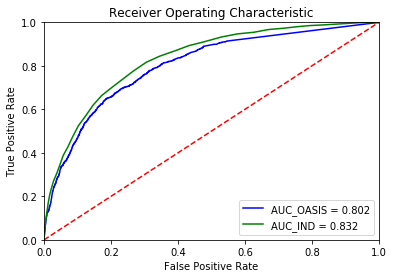

In [34]:


# create target variable
y = df_scores['icustay_expire_flag'].copy()

# create X variable
X = df_scores[['age_score', 'preiculos_score', 'gcs_score', 'heartrate_score', \
                              'meanbp_score', 'resprate_score', 'temp_score','urineoutput_score', \
                              'mechvent_score','electivesurgery_score']].copy()


# train-test split	
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                test_size=.33,
                                                random_state=0,
                                               stratify=y)

# Train and fit model                                                   
rf = RandomForestClassifier(n_estimators = 300, random_state=0,n_jobs=-1)

rf.fit(X_train, y_train)

# Test Prediction
pred = rf.predict(X_test)
print('Accuracy score: {:.3}'.format(rf.score(X_test, y_test)))

# Get predicted probabilites 	
y_predict_proba = rf.predict_proba(X_test)

# Get predicted probabilites of 1 (Death)
y_proba = y_predict_proba[:,1]

# Get AUROC score
print('AUROC: {:.3}'.format(roc_auc_score(y_test, y_proba)))

# Calculate Standard Mortality Rate (SMR) 
SMR = sum(y_test)/sum(pred)
print('SMR: {:.3}'.format(SMR))
# (different way) print('SMR: {:.3}'.format(sum(y_test)/sum(pred)))

# Calculate Brier score
difference = y_proba - y_test
squared = np.square(difference)
Brier = np.mean(squared)
print('Brier Score: {:.3}'.format(Brier))
# (different way) print('Brier Score: {:.3}'.format(np.mean(np.square(y_proba - y_test))))
print('Brier Score [IND]: {:.3}'.format(np.mean(np.square(y_ind_prob['oasis_prob'] - y_test))))


# calculate the fpr and tpr for all thresholds of the classification
# probs = model.predict_proba(X_test)
# preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Industry standard 
fpr_IND, tpr_IND, threshold = roc_curve(y_test, y_ind_prob['oasis_prob'])
roc_auc_IND = auc(fpr_IND, tpr_IND)

# Plot ROC curves

plt.title('Receiver Operating Characteristic')

plt.plot(fpr, tpr, 'b', label = 'AUC_OASIS = %0.3f' % roc_auc)
plt.plot(fpr_IND, tpr_IND, 'g', label = 'AUC_IND = %0.3f' % roc_auc_IND)


plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## LIMITING MAX DEPTH TO 10

Accuracy score: 0.926
AUROC: 0.857
SMR: 4.06
Brier Score: 0.0587
Brier Score [IND]: 0.0681


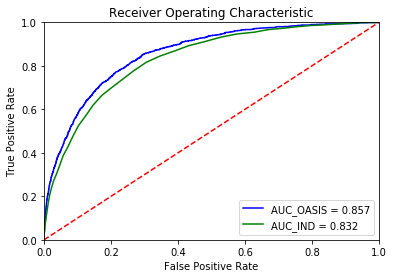

In [38]:


# create target variable
y = df_scores['icustay_expire_flag'].copy()

# create X variable
X = df_scores[['age_score', 'preiculos_score' ,'gcs_score', 'heartrate_score', \
                              'meanbp_score', 'resprate_score', 'temp_score','urineoutput_score', \
                              'mechvent_score','electivesurgery_score']].copy()


# train-test split	
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                test_size=.33,
                                                random_state=0,
                                               stratify=y)

# Train and fit model                                                   
rf = RandomForestClassifier(n_estimators = 300, random_state=0,max_depth=10, n_jobs=-1)

rf.fit(X_train, y_train)

# Test Prediction
pred = rf.predict(X_test)
print('Accuracy score: {:.3}'.format(rf.score(X_test, y_test)))

# Get predicted probabilites 	
y_predict_proba = rf.predict_proba(X_test)

# Get predicted probabilites of 1 (Death)
y_proba = y_predict_proba[:,1]

# Get AUROC score
print('AUROC: {:.3}'.format(roc_auc_score(y_test, y_proba)))

# Calculate Standard Mortality Rate (SMR) 
SMR = sum(y_test)/sum(pred)
print('SMR: {:.3}'.format(SMR))
# (different way) print('SMR: {:.3}'.format(sum(y_test)/sum(pred)))

# Calculate Brier score
difference = y_proba - y_test
squared = np.square(difference)
Brier = np.mean(squared)
print('Brier Score: {:.3}'.format(Brier))
# (different way) print('Brier Score: {:.3}'.format(np.mean(np.square(y_proba - y_test))))
print('Brier Score [IND]: {:.3}'.format(np.mean(np.square(y_ind_prob['oasis_prob'] - y_test))))


# calculate the fpr and tpr for all thresholds of the classification
# probs = model.predict_proba(X_test)
# preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Industry standard 
fpr_IND, tpr_IND, threshold = roc_curve(y_test, y_ind_prob['oasis_prob'])
roc_auc_IND = auc(fpr_IND, tpr_IND)

# Plot ROC curves

plt.title('Receiver Operating Characteristic')

plt.plot(fpr, tpr, 'b', label = 'AUC_OASIS = %0.3f' % roc_auc)
plt.plot(fpr_IND, tpr_IND, 'g', label = 'AUC_IND = %0.3f' % roc_auc_IND)


plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## RAW SCORES (w/o 'PREICULOS')

Accuracy score: 0.927
AUROC: 0.856
SMR: 3.4
Brier Score: 0.0578
Brier Score [IND]: 0.0681


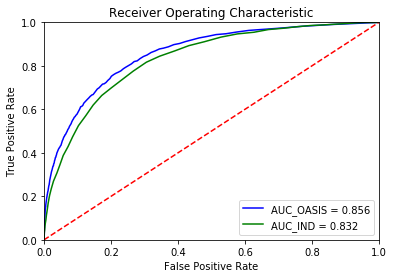

In [9]:


# create target variable
y = df_raw['icustay_expire_flag'].copy()

# create X variable
X = df_raw[['age', 'gcs', 'heartrate', 'meanbp', \
		 'resprate', 'temp', 'urineoutput', 'mechvent','electivesurgery']].copy()


# train-test split	
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                test_size=.33,
                                                random_state=0,
                                               stratify=y)

y_ind_prob = df_raw.loc[X_test.index]
# Train and fit model                                                   
rf = RandomForestClassifier(n_estimators = 300, random_state=0,n_jobs=-1)

rf.fit(X_train, y_train)

# Test Prediction
pred = rf.predict(X_test)
print('Accuracy score: {:.3}'.format(rf.score(X_test, y_test)))

# Get predicted probabilites 	
y_predict_proba = rf.predict_proba(X_test)

# Get predicted probabilites of 1 (Death)
y_proba = y_predict_proba[:,1]

# Get AUROC score
print('AUROC: {:.3}'.format(roc_auc_score(y_test, y_proba)))

# Calculate Standard Mortality Rate (SMR) 
SMR = sum(y_test)/sum(pred)
print('SMR: {:.3}'.format(SMR))
# (different way) print('SMR: {:.3}'.format(sum(y_test)/sum(pred)))

# Calculate Brier score
difference = y_proba - y_test
squared = np.square(difference)
Brier = np.mean(squared)
print('Brier Score: {:.3}'.format(Brier))
# (different way) print('Brier Score: {:.3}'.format(np.mean(np.square(y_proba - y_test))))
print('Brier Score [IND]: {:.3}'.format(np.mean(np.square(y_ind_prob['oasis_prob'] - y_test))))


# calculate the fpr and tpr for all thresholds of the classification
# probs = model.predict_proba(X_test)
# preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Industry standard 
fpr_IND, tpr_IND, threshold = roc_curve(y_test, y_ind_prob['oasis_prob'])
roc_auc_IND = auc(fpr_IND, tpr_IND)

# Plot ROC curves

plt.title('Receiver Operating Characteristic')

plt.plot(fpr, tpr, 'b', label = 'AUC_OASIS = %0.3f' % roc_auc)
plt.plot(fpr_IND, tpr_IND, 'g', label = 'AUC_IND = %0.3f' % roc_auc_IND)


plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## TRIED DIFFERENT NUMBER OF TREES (MAX NO. OF ESTIMATORS)

10
Accuracy score: 0.924
AUROC: 0.791
SMR: 3.01
Brier Score: 0.0637
Brier Score [IND]: 0.0681


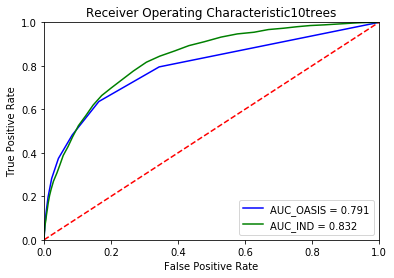

25
Accuracy score: 0.926
AUROC: 0.83
SMR: 2.94
Brier Score: 0.0597
Brier Score [IND]: 0.0681


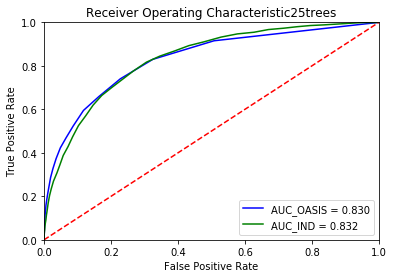

50
Accuracy score: 0.927
AUROC: 0.844
SMR: 3.35
Brier Score: 0.0586
Brier Score [IND]: 0.0681


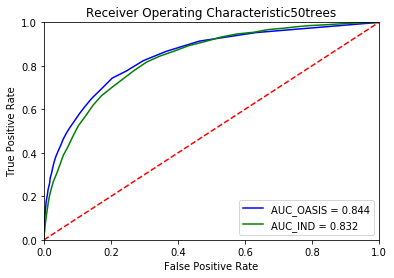

75
Accuracy score: 0.928
AUROC: 0.85
SMR: 3.33
Brier Score: 0.0582
Brier Score [IND]: 0.0681


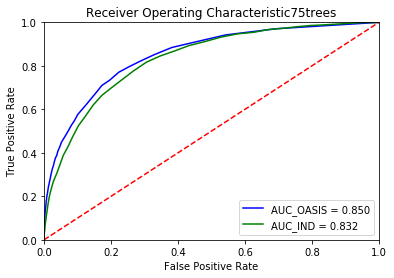

100
Accuracy score: 0.928
AUROC: 0.852
SMR: 3.45
Brier Score: 0.0581
Brier Score [IND]: 0.0681


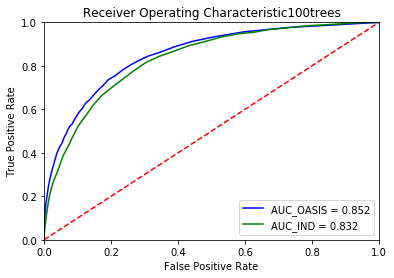

150
Accuracy score: 0.927
AUROC: 0.854
SMR: 3.44
Brier Score: 0.058
Brier Score [IND]: 0.0681


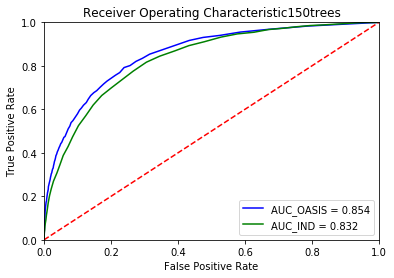

200
Accuracy score: 0.927
AUROC: 0.856
SMR: 3.4
Brier Score: 0.0578
Brier Score [IND]: 0.0681


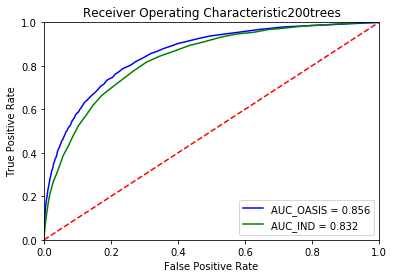

250
Accuracy score: 0.927
AUROC: 0.856
SMR: 3.44
Brier Score: 0.0579
Brier Score [IND]: 0.0681


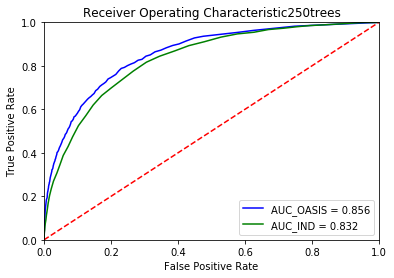

500
Accuracy score: 0.928
AUROC: 0.857
SMR: 3.31
Brier Score: 0.0578
Brier Score [IND]: 0.0681


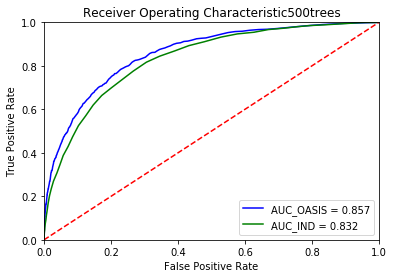

In [21]:


# create target variable
y = df_raw['icustay_expire_flag'].copy()

# create X variable
X = df_raw[['age', 'gcs', 'heartrate', 'meanbp', \
		 'resprate', 'temp', 'urineoutput', 'mechvent','electivesurgery']].copy()


# train-test split	
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                test_size=.33,
                                                random_state=0,
                                               stratify=y)

y_ind_prob = df_raw.loc[X_test.index]
    
n = [10, 25, 50, 75, 100, 150, 200, 250, 500]
for i in n:
    
    # Train and fit model                                                   
    rf = RandomForestClassifier(n_estimators = i, random_state=0,n_jobs=-1)

    rf.fit(X_train, y_train)
    print(i)
    # Test Prediction
    pred = rf.predict(X_test)
    print('Accuracy score: {:.3}'.format(rf.score(X_test, y_test)))

    # Get predicted probabilites 	
    y_predict_proba = rf.predict_proba(X_test)

    # Get predicted probabilites of 1 (Death)
    y_proba = y_predict_proba[:,1]

    # Get AUROC score
    print('AUROC: {:.3}'.format(roc_auc_score(y_test, y_proba)))

    # Calculate Standard Mortality Rate (SMR) 
    SMR = sum(y_test)/sum(pred)
    print('SMR: {:.3}'.format(SMR))
    # (different way) print('SMR: {:.3}'.format(sum(y_test)/sum(pred)))

    # Calculate Brier score
    difference = y_proba - y_test
    squared = np.square(difference)
    Brier = np.mean(squared)
    print('Brier Score: {:.3}'.format(Brier))
    # (different way) print('Brier Score: {:.3}'.format(np.mean(np.square(y_proba - y_test))))
    print('Brier Score [IND]: {:.3}'.format(np.mean(np.square(y_ind_prob['oasis_prob'] - y_test))))


    # calculate the fpr and tpr for all thresholds of the classification
    # probs = model.predict_proba(X_test)
    # preds = probs[:,1]
    fpr, tpr, threshold = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    # Industry standard 
    fpr_IND, tpr_IND, threshold = roc_curve(y_test, y_ind_prob['oasis_prob'])
    roc_auc_IND = auc(fpr_IND, tpr_IND)

    # Plot ROC curves

    plt.title('Receiver Operating Characteristic' + str(i) +'trees')

    plt.plot(fpr, tpr, 'b', label = 'AUC_OASIS = %0.3f' % roc_auc)
    plt.plot(fpr_IND, tpr_IND, 'g', label = 'AUC_IND = %0.3f' % roc_auc_IND)


    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

## OASIS SCORES w/o PREICULOS SCORE

Accuracy score: 0.917
AUROC: 0.79
SMR: 2.17
Brier Score: 0.0679
Brier Score [IND]: 0.0681


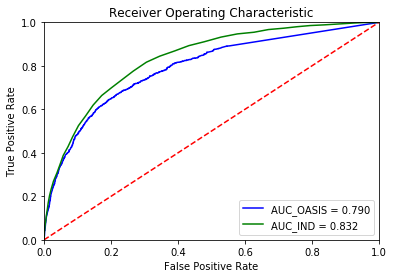

In [16]:


# create target variable
y = df_scores['icustay_expire_flag'].copy()

# create X variable
X = df_scores[['age_score',  'gcs_score', 'heartrate_score', \
                              'meanbp_score', 'resprate_score', 'temp_score','urineoutput_score', \
                              'mechvent_score','electivesurgery_score']].copy()


# train-test split	
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                test_size=.33,
                                                random_state=0,
                                               stratify=y)

# Train and fit model                                                   
rf = RandomForestClassifier(n_estimators = 300, random_state=0,n_jobs=-1)

rf.fit(X_train, y_train)

# Test Prediction
pred = rf.predict(X_test)
print('Accuracy score: {:.3}'.format(rf.score(X_test, y_test)))

# Get predicted probabilites 	
y_predict_proba = rf.predict_proba(X_test)

# Get predicted probabilites of 1 (Death)
y_proba = y_predict_proba[:,1]

# Get AUROC score
print('AUROC: {:.3}'.format(roc_auc_score(y_test, y_proba)))

# Calculate Standard Mortality Rate (SMR) 
SMR = sum(y_test)/sum(pred)
print('SMR: {:.3}'.format(SMR))
# (different way) print('SMR: {:.3}'.format(sum(y_test)/sum(pred)))

# Calculate Brier score
difference = y_proba - y_test
squared = np.square(difference)
Brier = np.mean(squared)
print('Brier Score: {:.3}'.format(Brier))
# (different way) print('Brier Score: {:.3}'.format(np.mean(np.square(y_proba - y_test))))
print('Brier Score [IND]: {:.3}'.format(np.mean(np.square(y_ind_prob['oasis_prob'] - y_test))))


# calculate the fpr and tpr for all thresholds of the classification
# probs = model.predict_proba(X_test)
# preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Industry standard 
fpr_IND, tpr_IND, threshold = roc_curve(y_test, y_ind_prob['oasis_prob'])
roc_auc_IND = auc(fpr_IND, tpr_IND)

# Plot ROC curves

plt.title('Receiver Operating Characteristic')

plt.plot(fpr, tpr, 'b', label = 'AUC_OASIS = %0.3f' % roc_auc)
plt.plot(fpr_IND, tpr_IND, 'g', label = 'AUC_IND = %0.3f' % roc_auc_IND)


plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [11]:
SMR = sum(y_test)/sum(y_proba)
SMR

0.94078623366848912

## OASIS RAW SCORES, VARYING NUMBER OF TREES


1
Accuracy score: 0.919
AUROC: 0.8
SMR: inf
Brier Score: 0.0693
Brier Score [IND]: 0.0681


/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in long_scalars


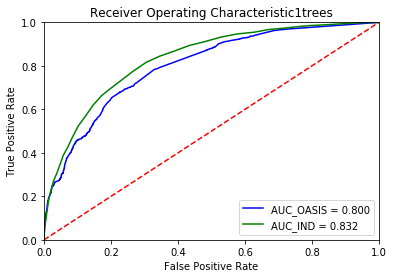

2
Accuracy score: 0.919
AUROC: 0.818
SMR: inf
Brier Score: 0.0658
Brier Score [IND]: 0.0681


/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in long_scalars


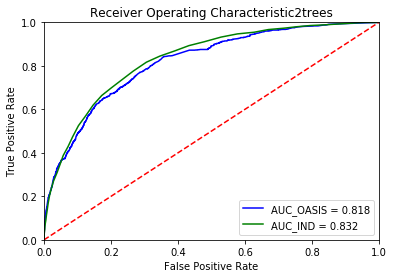

3
Accuracy score: 0.921
AUROC: 0.831
SMR: 31.7
Brier Score: 0.0634
Brier Score [IND]: 0.0681


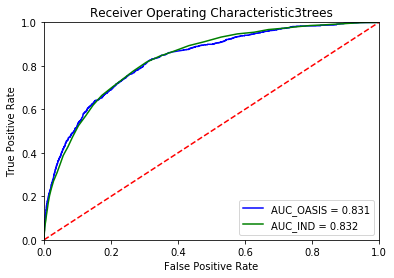

4
Accuracy score: 0.923
AUROC: 0.841
SMR: 11.6
Brier Score: 0.0616
Brier Score [IND]: 0.0681


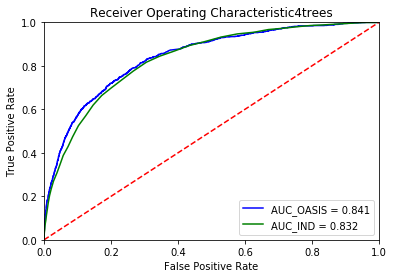

5
Accuracy score: 0.925
AUROC: 0.847
SMR: 8.33
Brier Score: 0.0603
Brier Score [IND]: 0.0681


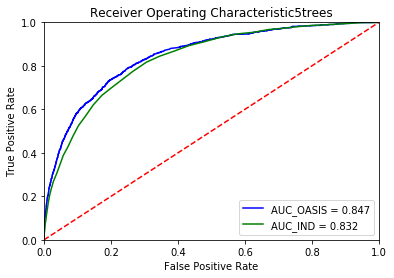

6
Accuracy score: 0.926
AUROC: 0.854
SMR: 7.06
Brier Score: 0.0593
Brier Score [IND]: 0.0681


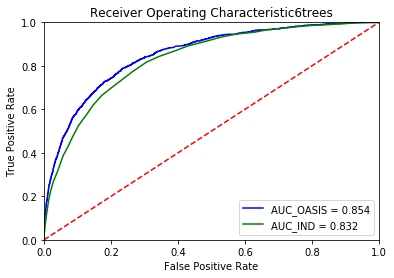

7
Accuracy score: 0.926
AUROC: 0.857
SMR: 5.8
Brier Score: 0.0586
Brier Score [IND]: 0.0681


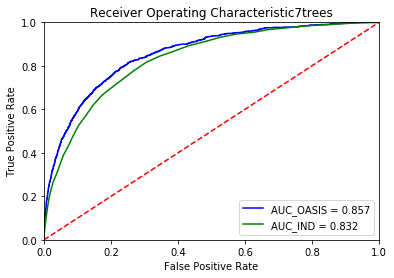

8
Accuracy score: 0.927
AUROC: 0.859
SMR: 5.24
Brier Score: 0.0581
Brier Score [IND]: 0.0681


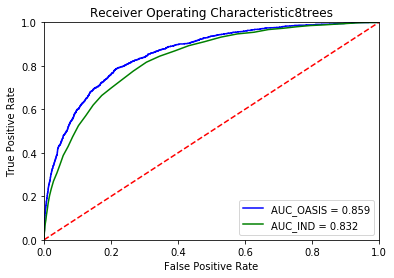

9
Accuracy score: 0.928
AUROC: 0.861
SMR: 4.88
Brier Score: 0.0578
Brier Score [IND]: 0.0681


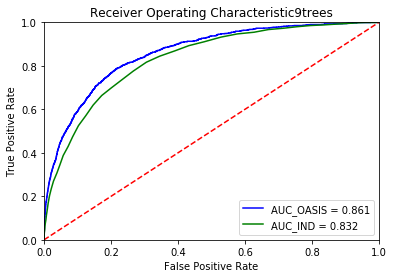

10
Accuracy score: 0.928
AUROC: 0.862
SMR: 4.48
Brier Score: 0.0575
Brier Score [IND]: 0.0681


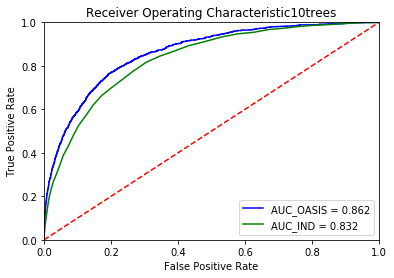

20
Accuracy score: 0.927
AUROC: 0.857
SMR: 3.44
Brier Score: 0.0577
Brier Score [IND]: 0.0681


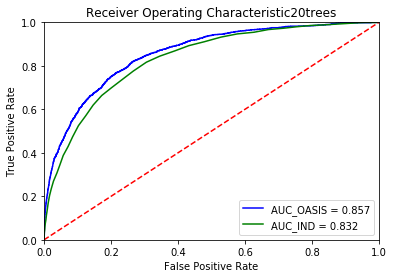

40
Accuracy score: 0.927
AUROC: 0.856
SMR: 3.4
Brier Score: 0.0578
Brier Score [IND]: 0.0681


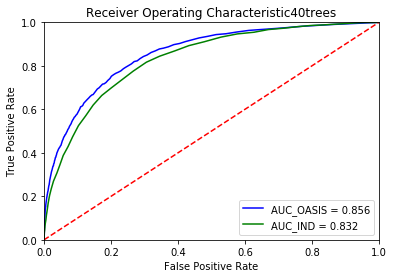

60
Accuracy score: 0.927
AUROC: 0.856
SMR: 3.4
Brier Score: 0.0578
Brier Score [IND]: 0.0681


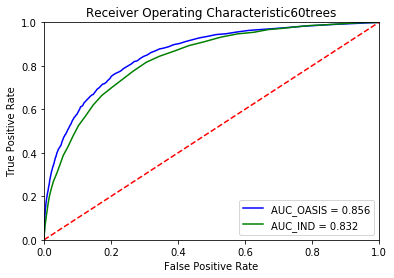

100
Accuracy score: 0.927
AUROC: 0.856
SMR: 3.4
Brier Score: 0.0578
Brier Score [IND]: 0.0681


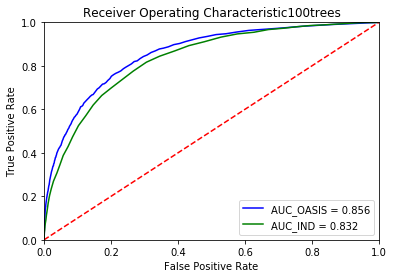

In [25]:


# create target variable
y = df_raw['icustay_expire_flag'].copy()

# create X variable
X = df_raw[['age', 'gcs', 'heartrate', 'meanbp', \
		 'resprate', 'temp', 'urineoutput', 'mechvent','electivesurgery']].copy()


# train-test split	
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                test_size=.33,
                                                random_state=0,
                                               stratify=y)

y_ind_prob = df_raw.loc[X_test.index]
    
n = [1,2,3,4,5,6,7,8,9,10,20,40,60,100]
for i in n:
    
    # Train and fit model                                                   
    rf = RandomForestClassifier(n_estimators = 300, max_depth=i, random_state=0,n_jobs=-1)

    rf.fit(X_train, y_train)
    print(i)
    # Test Prediction
    pred = rf.predict(X_test)
    print('Accuracy score: {:.3}'.format(rf.score(X_test, y_test)))

    # Get predicted probabilites 	
    y_predict_proba = rf.predict_proba(X_test)

    # Get predicted probabilites of 1 (Death)
    y_proba = y_predict_proba[:,1]

    # Get AUROC score
    print('AUROC: {:.3}'.format(roc_auc_score(y_test, y_proba)))

    # Calculate Standard Mortality Rate (SMR) 
    SMR = sum(y_test)/sum(pred)
    print('SMR: {:.3}'.format(SMR))
    # (different way) print('SMR: {:.3}'.format(sum(y_test)/sum(pred)))

    # Calculate Brier score
    difference = y_proba - y_test
    squared = np.square(difference)
    Brier = np.mean(squared)
    print('Brier Score: {:.3}'.format(Brier))
    # (different way) print('Brier Score: {:.3}'.format(np.mean(np.square(y_proba - y_test))))
    print('Brier Score [IND]: {:.3}'.format(np.mean(np.square(y_ind_prob['oasis_prob'] - y_test))))


    # calculate the fpr and tpr for all thresholds of the classification
    # probs = model.predict_proba(X_test)
    # preds = probs[:,1]
    fpr, tpr, threshold = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    # Industry standard 
    fpr_IND, tpr_IND, threshold = roc_curve(y_test, y_ind_prob['oasis_prob'])
    roc_auc_IND = auc(fpr_IND, tpr_IND)

    # Plot ROC curves

    plt.title('Receiver Operating Characteristic' + str(i) +'trees')

    plt.plot(fpr, tpr, 'b', label = 'AUC_OASIS = %0.3f' % roc_auc)
    plt.plot(fpr_IND, tpr_IND, 'g', label = 'AUC_IND = %0.3f' % roc_auc_IND)


    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

## OASIS RAW SCORES, VARYING NUMBER OF TREES

100
Accuracy score: 0.927
AUROC: 0.856
SMR: 3.4
Brier Score: 0.0578
Brier Score [IND]: 0.0681


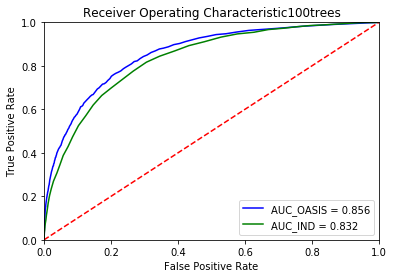

200
Accuracy score: 0.927
AUROC: 0.856
SMR: 3.4
Brier Score: 0.0578
Brier Score [IND]: 0.0681


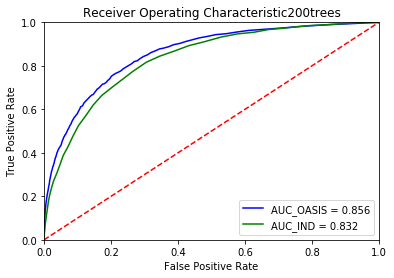

300
Accuracy score: 0.927
AUROC: 0.856
SMR: 3.4
Brier Score: 0.0578
Brier Score [IND]: 0.0681


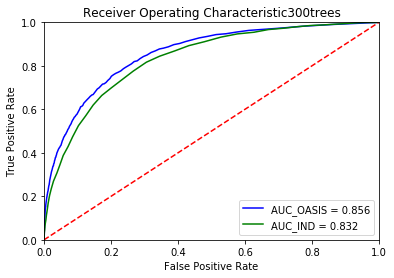

400
Accuracy score: 0.927
AUROC: 0.856
SMR: 3.4
Brier Score: 0.0578
Brier Score [IND]: 0.0681


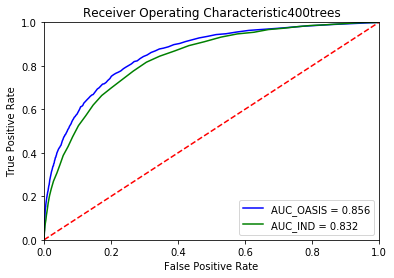

500
Accuracy score: 0.927
AUROC: 0.856
SMR: 3.4
Brier Score: 0.0578
Brier Score [IND]: 0.0681


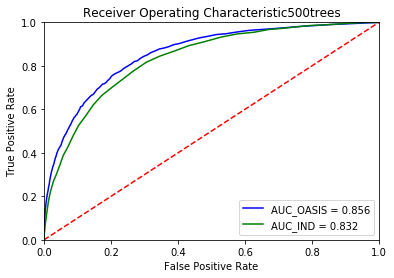

600
Accuracy score: 0.927
AUROC: 0.856
SMR: 3.4
Brier Score: 0.0578
Brier Score [IND]: 0.0681


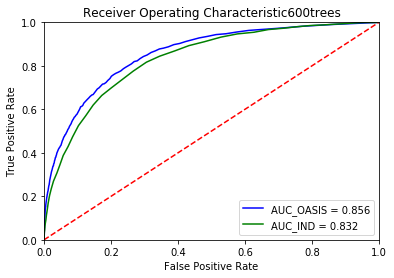

1000
Accuracy score: 0.927
AUROC: 0.856
SMR: 3.4
Brier Score: 0.0578
Brier Score [IND]: 0.0681


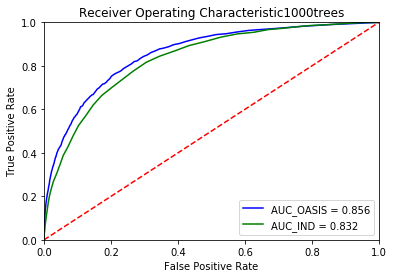

In [39]:


# create target variable
y = df_raw['icustay_expire_flag'].copy()

# create X variable
X = df_raw[['age', 'gcs', 'heartrate', 'meanbp', \
		 'resprate', 'temp', 'urineoutput', 'mechvent','electivesurgery']].copy()


# train-test split	
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                test_size=.33,
                                                random_state=0,
                                               stratify=y)

y_ind_prob = df_raw.loc[X_test.index]
    
n = [100,200,300,400,500,600,1000]
for i in n:
    
    # Train and fit model                                                   
    rf = RandomForestClassifier(n_estimators = 300, max_depth=i, random_state=0,n_jobs=-1)

    rf.fit(X_train, y_train)
    print(i)
    # Test Prediction
    pred = rf.predict(X_test)
    print('Accuracy score: {:.3}'.format(rf.score(X_test, y_test)))

    # Get predicted probabilites 	
    y_predict_proba = rf.predict_proba(X_test)

    # Get predicted probabilites of 1 (Death)
    y_proba = y_predict_proba[:,1]

    # Get AUROC score
    print('AUROC: {:.3}'.format(roc_auc_score(y_test, y_proba)))

    # Calculate Standard Mortality Rate (SMR) 
    SMR = sum(y_test)/sum(pred)
    print('SMR: {:.3}'.format(SMR))
    # (different way) print('SMR: {:.3}'.format(sum(y_test)/sum(pred)))

    # Calculate Brier score
    difference = y_proba - y_test
    squared = np.square(difference)
    Brier = np.mean(squared)
    print('Brier Score: {:.3}'.format(Brier))
    # (different way) print('Brier Score: {:.3}'.format(np.mean(np.square(y_proba - y_test))))
    print('Brier Score [IND]: {:.3}'.format(np.mean(np.square(y_ind_prob['oasis_prob'] - y_test))))


    # calculate the fpr and tpr for all thresholds of the classification
    # probs = model.predict_proba(X_test)
    # preds = probs[:,1]
    fpr, tpr, threshold = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    # Industry standard 
    fpr_IND, tpr_IND, threshold = roc_curve(y_test, y_ind_prob['oasis_prob'])
    roc_auc_IND = auc(fpr_IND, tpr_IND)

    # Plot ROC curves

    plt.title('Receiver Operating Characteristic' + str(i) +'trees')

    plt.plot(fpr, tpr, 'b', label = 'AUC_OASIS = %0.3f' % roc_auc)
    plt.plot(fpr_IND, tpr_IND, 'g', label = 'AUC_IND = %0.3f' % roc_auc_IND)


    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

10
Accuracy score: 0.926
AUROC: 0.857
SMR: 4.06
Brier Score: 0.0587
Brier Score [IND]: 0.0681


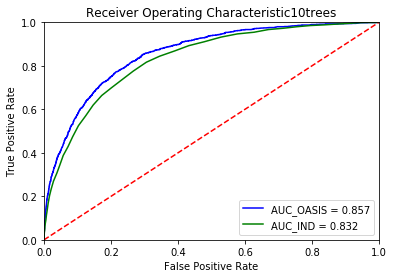

11
Accuracy score: 0.926
AUROC: 0.857
SMR: 3.87
Brier Score: 0.0588
Brier Score [IND]: 0.0681


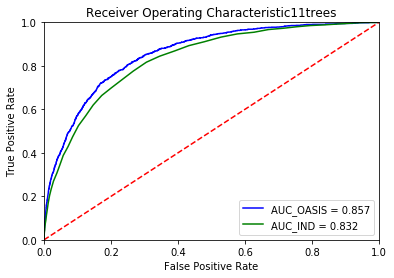

12
Accuracy score: 0.926
AUROC: 0.854
SMR: 3.52
Brier Score: 0.0594
Brier Score [IND]: 0.0681


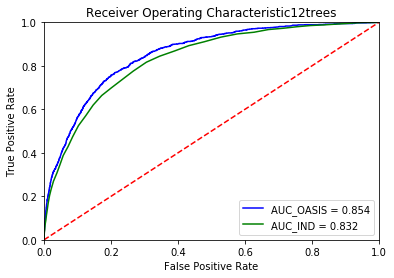

13
Accuracy score: 0.924
AUROC: 0.85
SMR: 3.23
Brier Score: 0.0602
Brier Score [IND]: 0.0681


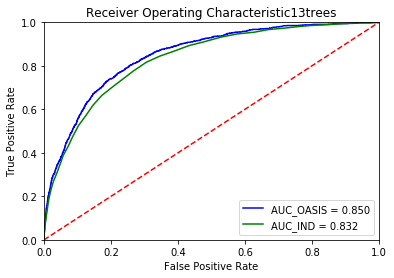

14
Accuracy score: 0.923
AUROC: 0.844
SMR: 2.93
Brier Score: 0.0612
Brier Score [IND]: 0.0681


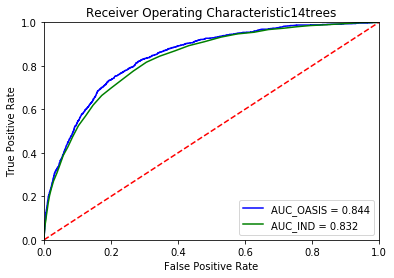

15
Accuracy score: 0.921
AUROC: 0.837
SMR: 2.62
Brier Score: 0.0626
Brier Score [IND]: 0.0681


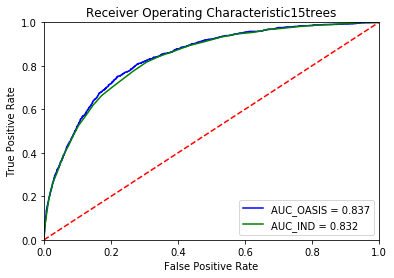

16
Accuracy score: 0.919
AUROC: 0.831
SMR: 2.39
Brier Score: 0.0642
Brier Score [IND]: 0.0681


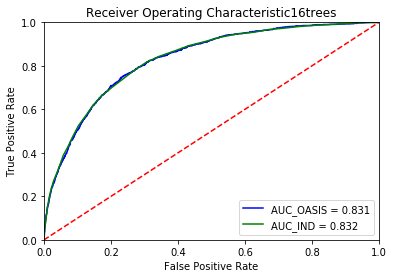

17
Accuracy score: 0.916
AUROC: 0.824
SMR: 2.12
Brier Score: 0.0657
Brier Score [IND]: 0.0681


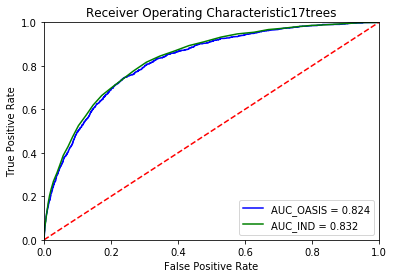

18
Accuracy score: 0.915
AUROC: 0.816
SMR: 2.04
Brier Score: 0.0672
Brier Score [IND]: 0.0681


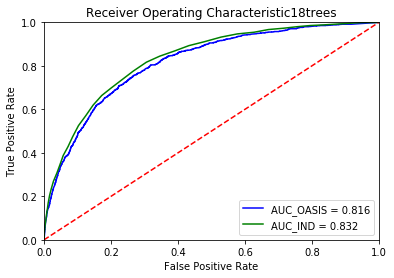

19
Accuracy score: 0.913
AUROC: 0.813
SMR: 1.96
Brier Score: 0.0681
Brier Score [IND]: 0.0681


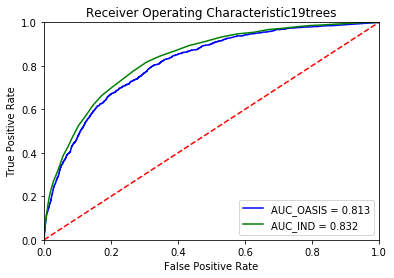

20
Accuracy score: 0.914
AUROC: 0.81
SMR: 1.93
Brier Score: 0.0687
Brier Score [IND]: 0.0681


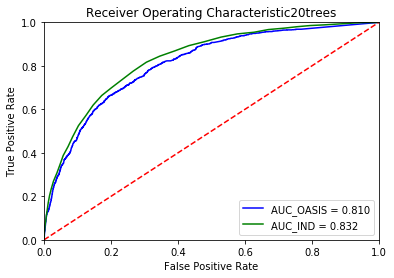

21
Accuracy score: 0.914
AUROC: 0.808
SMR: 1.95
Brier Score: 0.0689
Brier Score [IND]: 0.0681


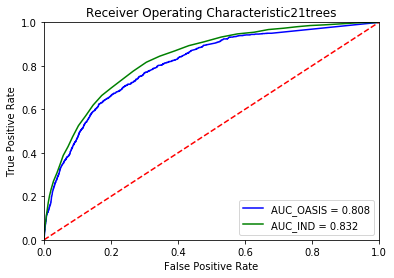

22
Accuracy score: 0.913
AUROC: 0.805
SMR: 1.92
Brier Score: 0.0692
Brier Score [IND]: 0.0681


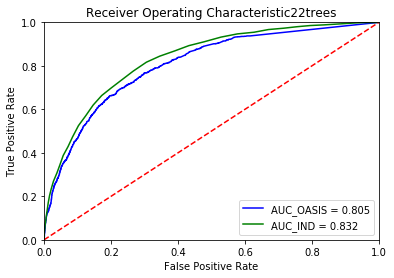

23
Accuracy score: 0.913
AUROC: 0.803
SMR: 1.95
Brier Score: 0.0692
Brier Score [IND]: 0.0681


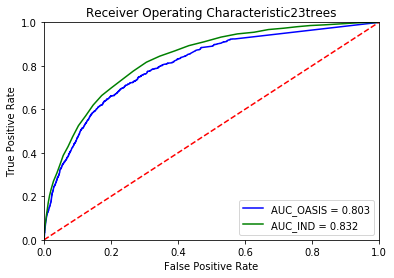

24
Accuracy score: 0.914
AUROC: 0.802
SMR: 1.93
Brier Score: 0.0692
Brier Score [IND]: 0.0681


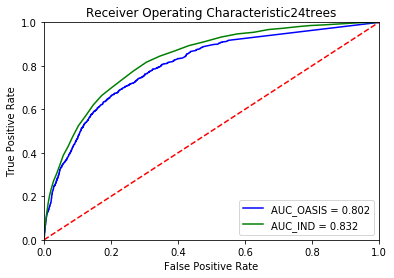

25
Accuracy score: 0.914
AUROC: 0.802
SMR: 1.92
Brier Score: 0.0692
Brier Score [IND]: 0.0681


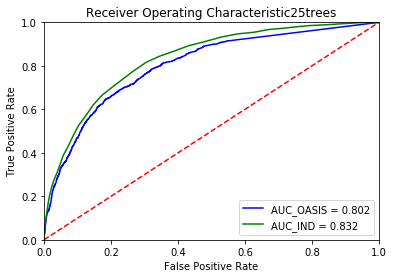

In [42]:


# create target variable
y = df_scores['icustay_expire_flag'].copy()

# create X variable
X = df_scores[['age_score', 'preiculos_score', 'gcs_score', 'heartrate_score', \
                              'meanbp_score', 'resprate_score', 'temp_score','urineoutput_score', \
                              'mechvent_score','electivesurgery_score']].copy()


# train-test split	
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                test_size=.33,
                                                random_state=0,
                                               stratify=y)

y_ind_prob = df_scores.loc[X_test.index]
    
n = [10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25]
for i in n:
    
    # Train and fit model                                                   
    rf = RandomForestClassifier(n_estimators = 300, max_depth=i, random_state=0,n_jobs=-1)

    rf.fit(X_train, y_train)
    print(i)
    # Test Prediction
    pred = rf.predict(X_test)
    print('Accuracy score: {:.3}'.format(rf.score(X_test, y_test)))

    # Get predicted probabilites 	
    y_predict_proba = rf.predict_proba(X_test)

    # Get predicted probabilites of 1 (Death)
    y_proba = y_predict_proba[:,1]

    # Get AUROC score
    print('AUROC: {:.3}'.format(roc_auc_score(y_test, y_proba)))

    # Calculate Standard Mortality Rate (SMR) 
    SMR = sum(y_test)/sum(pred)
    print('SMR: {:.3}'.format(SMR))
    # (different way) print('SMR: {:.3}'.format(sum(y_test)/sum(pred)))

    # Calculate Brier score
    difference = y_proba - y_test
    squared = np.square(difference)
    Brier = np.mean(squared)
    print('Brier Score: {:.3}'.format(Brier))
    # (different way) print('Brier Score: {:.3}'.format(np.mean(np.square(y_proba - y_test))))
    print('Brier Score [IND]: {:.3}'.format(np.mean(np.square(y_ind_prob['oasis_prob'] - y_test))))


    # calculate the fpr and tpr for all thresholds of the classification
    # probs = model.predict_proba(X_test)
    # preds = probs[:,1]
    fpr, tpr, threshold = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    # Industry standard 
    fpr_IND, tpr_IND, threshold = roc_curve(y_test, y_ind_prob['oasis_prob'])
    roc_auc_IND = auc(fpr_IND, tpr_IND)

    # Plot ROC curves

    plt.title('Receiver Operating Characteristic' + str(i) +'trees')

    plt.plot(fpr, tpr, 'b', label = 'AUC_OASIS = %0.3f' % roc_auc)
    plt.plot(fpr_IND, tpr_IND, 'g', label = 'AUC_IND = %0.3f' % roc_auc_IND)


    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

## Untuned Gradient Boosted Tree OASIS scores

Accuracy score: 0.926
AUROC: 0.863
SMR: 3.43
Brier Score: 0.0581
Brier Score [IND]: 0.0681


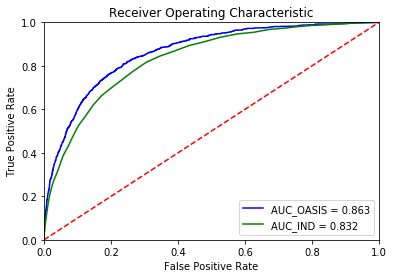

In [50]:


# create target variable
y = df_scores['icustay_expire_flag'].copy()

# create X variable
X = df_scores[['age_score', 'preiculos_score', 'gcs_score', 'heartrate_score', \
                              'meanbp_score', 'resprate_score', 'temp_score','urineoutput_score', \
                              'mechvent_score','electivesurgery_score']].copy()


# train-test split	
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                test_size=.33,
                                                random_state=0,
                                               stratify=y)

# Train and fit model                                                   
rf = GradientBoostingClassifier( random_state=0)

rf.fit(X_train, y_train)

# Test Prediction
pred = rf.predict(X_test)
print('Accuracy score: {:.3}'.format(rf.score(X_test, y_test)))

# Get predicted probabilites 	
y_predict_proba = rf.predict_proba(X_test)

# Get predicted probabilites of 1 (Death)
y_proba = y_predict_proba[:,1]

# Get AUROC score
print('AUROC: {:.3}'.format(roc_auc_score(y_test, y_proba)))

# Calculate Standard Mortality Rate (SMR) 
SMR = sum(y_test)/sum(pred)
print('SMR: {:.3}'.format(SMR))
# (different way) print('SMR: {:.3}'.format(sum(y_test)/sum(pred)))

# Calculate Brier score
difference = y_proba - y_test
squared = np.square(difference)
Brier = np.mean(squared)
print('Brier Score: {:.3}'.format(Brier))
# (different way) print('Brier Score: {:.3}'.format(np.mean(np.square(y_proba - y_test))))
print('Brier Score [IND]: {:.3}'.format(np.mean(np.square(y_ind_prob['oasis_prob'] - y_test))))


# calculate the fpr and tpr for all thresholds of the classification
# probs = model.predict_proba(X_test)
# preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Industry standard 
fpr_IND, tpr_IND, threshold = roc_curve(y_test, y_ind_prob['oasis_prob'])
roc_auc_IND = auc(fpr_IND, tpr_IND)

# Plot ROC curves

plt.title('Receiver Operating Characteristic')

plt.plot(fpr, tpr, 'b', label = 'AUC_OASIS = %0.3f' % roc_auc)
plt.plot(fpr_IND, tpr_IND, 'g', label = 'AUC_IND = %0.3f' % roc_auc_IND)


plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Accuracy score: 0.927
AUROC: 0.865
SMR: 3.22
Brier Score: 0.0572
Brier Score [IND]: 0.0681


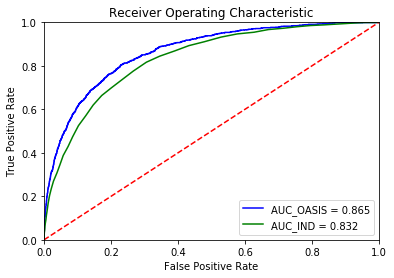

In [52]:


# create target variable
y = df_raw['icustay_expire_flag'].copy()

# create X variable
X = df_raw[['age', 'gcs', 'heartrate', 'meanbp', \
		 'resprate', 'temp', 'urineoutput', 'mechvent','electivesurgery']].copy()


# train-test split	
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                test_size=.33,
                                                random_state=0,
                                               stratify=y)

y_ind_prob = df_raw.loc[X_test.index]
# Train and fit model                                                   
rf = GradientBoostingClassifier( random_state=0)

rf.fit(X_train, y_train)

# Test Prediction
pred = rf.predict(X_test)
print('Accuracy score: {:.3}'.format(rf.score(X_test, y_test)))

# Get predicted probabilites 	
y_predict_proba = rf.predict_proba(X_test)

# Get predicted probabilites of 1 (Death)
y_proba = y_predict_proba[:,1]

# Get AUROC score
print('AUROC: {:.3}'.format(roc_auc_score(y_test, y_proba)))

# Calculate Standard Mortality Rate (SMR) 
SMR = sum(y_test)/sum(pred)
print('SMR: {:.3}'.format(SMR))
# (different way) print('SMR: {:.3}'.format(sum(y_test)/sum(pred)))

# Calculate Brier score
difference = y_proba - y_test
squared = np.square(difference)
Brier = np.mean(squared)
print('Brier Score: {:.3}'.format(Brier))
# (different way) print('Brier Score: {:.3}'.format(np.mean(np.square(y_proba - y_test))))
print('Brier Score [IND]: {:.3}'.format(np.mean(np.square(y_ind_prob['oasis_prob'] - y_test))))


# calculate the fpr and tpr for all thresholds of the classification
# probs = model.predict_proba(X_test)
# preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Industry standard 
fpr_IND, tpr_IND, threshold = roc_curve(y_test, y_ind_prob['oasis_prob'])
roc_auc_IND = auc(fpr_IND, tpr_IND)

# Plot ROC curves

plt.title('Receiver Operating Characteristic')

plt.plot(fpr, tpr, 'b', label = 'AUC_OASIS = %0.3f' % roc_auc)
plt.plot(fpr_IND, tpr_IND, 'g', label = 'AUC_IND = %0.3f' % roc_auc_IND)


plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

(array([ 12960.,   1654.,    574.,    320.,    183.,    127.,     92.,
            82.,     53.,     55.]),
 array([ 0.00562499,  0.10372021,  0.20181543,  0.29991065,  0.39800587,
         0.49610109,  0.59419631,  0.69229153,  0.79038675,  0.88848197,
         0.98657719]),
 <a list of 10 Patch objects>)

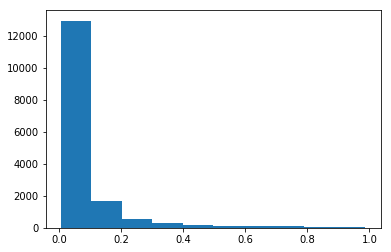

In [56]:
plt.hist(y_proba, bins=10)

In [58]:
sum(y_proba)

1294.2851823953783

In [55]:
sum(y_test)

1299

In [12]:
y_test.shape

(16100,)

In [29]:
df_scores['oasis_prob']

0        0.305849
1        0.152892
2        0.109623
3        0.054187
4        0.048012
5        0.029395
6        0.137099
7        0.048012
8        0.724202
9        0.017861
12       0.454600
14       0.279468
17       0.087098
18       0.152892
19       0.209226
20       0.048012
21       0.029395
22       0.042509
23       0.137099
24       0.042509
25       0.423212
27       0.109623
28       0.097783
29       0.033259
30       0.025967
31       0.068843
32       0.054187
36       0.012254
37       0.061106
38       0.087098
           ...   
61493    0.020241
61495    0.033259
61496    0.042509
61497    0.054187
61498    0.048012
61499    0.048012
61500    0.048012
61503    0.068843
61505    0.209226
61506    0.077479
61509    0.305849
61510    0.137099
61512    0.029395
61513    0.109623
61515    0.254529
61516    0.025967
61517    0.077479
61518    0.698023
61519    0.097783
61520    0.020241
61521    0.152892
61522    0.109623
61523    0.054187
61524    0.061106
61525    0

In [32]:
y_ind_prob = df_scores.loc[X_test.index]

In [36]:
len(y_ind_prob['oasis_prob'])

16100

In [37]:
roc_auc_score(y_test, y_ind_prob['oasis_prob'])

0.83201640090585394

In [42]:
rf.feature_importances_

array([ 0.12458589,  0.11951533,  0.10850778,  0.12517333,  0.10819621,
        0.10465079,  0.08748316,  0.14546385,  0.05595501,  0.02046864])